# Прогнозирование деффектов типа "кратер" при сварке трением с перемешиванием

## Введение
***Сварка*** - это один из способов неразъемного соединения металлоконструкций.

Одним из типов сварки является ***трением с перемешиванием***.
Эта современная технология применяется в авиакосмической отрасли. 
Она позволяет сваривать разные специализированные сплавы, включая алюминенвые, а так же сплавы магния, цинка и титана.

Это относительно новая технология. В России начать внедрение сварки трением с перемешиванием удалось только в новых российских ракетах.
Первой стала модульная «Ангара», сейчас эта технология применяется на омском ПО «Полёт» для сварки топливных баков универсальных ракетных модулей «Ангары».




### Схема процесса

Сварочные операции выплняется при помощи вращающегося инструмента, имеющего большую твёрдость, чем свариваемый материал, для соединения двух обращенных друг к другу заготовок без жидкой фазы материала заготовки. Можно выделить несколько этапов:

1) Вращающийся инструмент, погружается наконечником в стык свариваемых заготовок. Силы трения, вызванные высокой скоростью вращения, раскаляют металл до пластичного состояния.
2) Одновременно с вращением инструмент начинает линейное движение, продвигаясь вдоль шва и формируя единую сварочную ванну с равномерно распределенным веществом. Бурт давит на ванну, уплотняя материал и придавая зоне пластичного течения направленную форму.
3) По мере отдаления наконечника ванна начинает остывать. Проработав шов, то есть завершив линейное движение, инструмент извлекается. В конечной точке обычно остается небольшое отверстие от наконечника.

 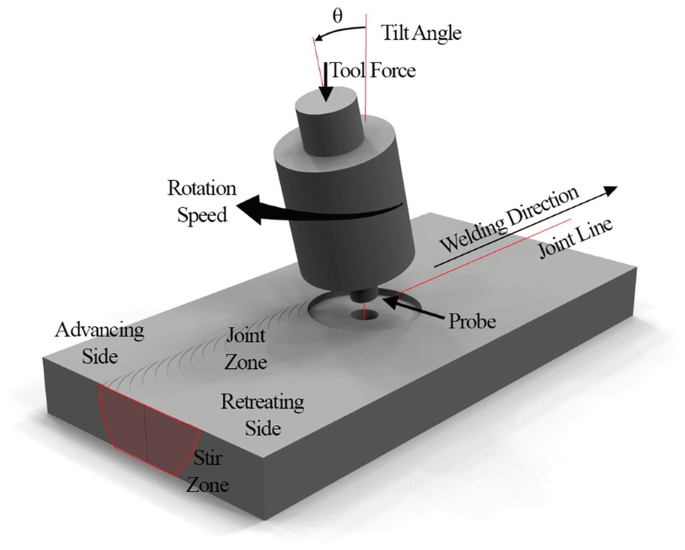 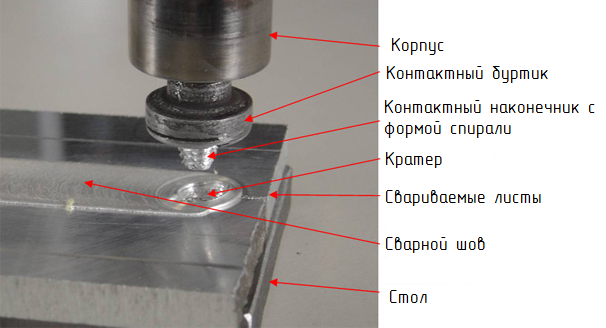 


## Постановка задачи.
В проекте решается задача определения наличия деффекта по значениям множества признаков, описывающих процесс сварки. Т.е. ***задача бинарной классификации***.
Одним из очевидных порходов являются алгоритм логистической регрессии или дерево решений.

## Датасет
Для анализа был найден [датасет](https://www.kaggle.com/datasets/arindambaruah/void-formation-process-data-in-welding?resource=download).
Данный датасет включает в себя информацию по режимам сварки, толщине и материалу свариваемых заготовок, геометрии инструмента.


### Знакомство с данными
Устанавливаем необходимые модули.



In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn

Импортируем необходимые модули

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Загружаем данные. 

In [ ]:
PATH = 'welding_process_parameters.csv'

data = pd.read_csv(PATH)
data.head()


Посмотрим количество строк и столбцов в датасете.

In [ ]:
data.shape

In [ ]:
data.columns

Многие столбцы распознаются как object, хотя по смыслу должны быть вещественнным числом.

In [ ]:
data.dtypes

Проверим, есть ли пропуски в данных. Видим, что пропуски практически отстутствуют, значит многие столбцы распознаются как строки.

In [ ]:
data.isna().sum()

### Очистка данных

Первая строка включает в себя обозначение единиц измерений, для анализа она не нужна. ***Удалим первую строку***.

Колонка `Alloy` является индексом, т.е. просто нумирует записи, начиная с 1. 
Однако содержит вещественные числа, поэтому лучше воспользоваться автоматической индексацией, а  `Alloy` ***удалить***.

In [ ]:
data = data.drop([0])
data = data.drop('Alloy', axis=1)
data = data.reset_index(drop=True)
data.head()

Колонка `Unnamed: 1` описывает ***тип сплава***, т.е. является категориальным признаком. Но из-за того, что он обозначается вещественным числом, возникает отношение порядка, хотя данные по своей сути номинальные.

Начнем с того, что переименуем столбец в `Alloy type`.

In [ ]:
data.rename(columns={'Unnamed: 1' : 'Alloy type'}, inplace=True)
data.head()

Посмотрим сколько у нас уникальных типов сплава, для этого преобразуем в строковый тип данных и воспользуемся методом `describe`.

Видим 3 уникальных типа.

In [ ]:
str_column = data['Alloy type'].astype(str)
str_column.describe()

В дальнейшем возможно придется перекодировать категориальные данные `Alloy type` методом OneHot. У нас всего 3 типа, что займет всего три новые колонки. Однако пока оставим как есть, для упрощения постоений визуализаций.

In [ ]:

# encoder = OneHotEncoder(handle_unknown='ignore')
# alloytype_column =  data.loc[:, ['Alloy type']] # извлекаем столбец как датафрейм
# encoder.fit(alloytype_column)
# print(encoder.categories_)

# cols_enc = encoder.transform(alloytype_column).toarray()
# cols_names = encoder.get_feature_names_out()
# new_data = pd.DataFrame(cols_enc, columns=cols_names)
# print(new_data)

# data = pd.concat([data, new_data], axis=1)
# data.drop('Alloy type', axis=1, inplace=True)


Рассмотрим колонку `Welding speed`. Она определилась как строка, потому что использует экспоненциальную запись. Преобразуем во `float`.
Также еще несколько колонок определились как строка, их также преобразуем. Колонки `Axial pressure` и `Tilt angle` содержат в некоторых записях символ `*` (например `13.00 *`). В описании датасета не дается пояснений этого обозначения. Поэтому принято решение удалить звездочку, а вещественное число оставить.

In [ ]:
cols_to_float = [
    'Welding speed',
    'Rotation speed',
    'Plate thickness',
    'Shoulder radius',
    'Pin root radius',
    'Pin tip radius',
    'Thermal diffusivity',
    'Yield strength',
    'Axial pressure',
    'Tilt angle'
]

cols_asteriks = ['Axial pressure', 'Tilt angle']

for name in cols_to_float:
    col = data[name]
    if name in cols_asteriks:
        col = col.map(lambda v: v.replace('*', '').strip())
    data[name] = col.astype(float)

data.dtypes
data

Также в датасете не расскрывается смысл колонки `Refs`. Указано, что это "источник данных". Можно предположить, что это номер установки или номер эксперимента.
В дальнейшем эта колонка скорее всего не понадобится. Удалим ее.

In [ ]:
data.drop('Refs', axis=1, inplace=True)

In [ ]:
data.dtypes

## Визуализация данных

Изучим матрицу корреляции признаков. 


Положительную корреляцию имеют размеры заготовки (`Plate thickness`) и геометрия инструмента (`Shoulder radius, Pin root radius, Pin tip radius`).
Это выглядит логично, поскольку размеры наконечника и буртика выбирают под толщину заготовки, чтобы проварить ее полностью.

Кроме того видно, что `Thermal diffusivity` имеет ярко выраженную отрицательную корреляцию с `Yield strength`. 
`Thermal diffusivity` - это скорость выравнивания температуры вещества, а `Yield strength` - это предел текучести сплава.
Получается, что чем выше прочность сплава, тем медленее выравнивается температура в зоне сварки.

Также отчетливо заметна отрицательная корреляция скорости вращения инструмента (`Rotation speed`) с геометрией инструмента, прочностью сплава  и толщинной заготовки.
Т.е. выбор скорости вращения инструмента скорее всего основывается именно на толщине  и материале заготовки. 
При этом скорость подача (`Welding speed`) не столько зависит от толщины заготовки, сколько от давления и типа сплава (предела текучести).

In [ ]:
import seaborn as sns

data_corr = data[data.columns.difference([
    'Void-1 void free-0',
    'Alloy type',
])]
print(data_corr.shape)
plt.figure(figsize=(10,10))
sns.heatmap(data_corr.corr())


Посмотрим как распредлено значение целевого признака наличия деффектов `Void-1 void free-0`.

In [ ]:
sns.countplot(data, x='Void-1 void free-0')

Посмотрим как признаки вляют на целевую переменную. Видно, что при низкой скорости вращения `Welding speed` и большом радиусе кончика инструмента `Pin tip radius` возникает больше деффектов. Это логично, так как на матрице корреляции выше мы видели, что эти признаки имеют отрицательную корреляцию друг с другом.

In [ ]:
data_plot = data

exclude_features  = [ 'Void-1 void free-0',
    'Alloy type',
    'Tilt angle']
for feature_name in data:
    if feature_name not in exclude_features:
        sns.catplot(data=data_plot, 
                    y=feature_name, 
                    x="Void-1 void free-0", 
                    kind="box")


У ящика с усами для признака скорости сварки `Welding speed` присутствует много выбросов. Посчитаем их количество. Получается 9 строк, все они относятся к одному типу сплава. В 3/9 случаев возникает деффект.
Сплав 6061 имеет хорошую свариваемость. Судя по исследованиям обычно операция выполнется с подачей в предлах 100мм/мин ( 0.0016 м/c). Поэтому смело удаляем выбросы.


In [ ]:
outliners = data[data['Welding speed'] > 0.005]
outlines_num_deffects = outliners['Void-1 void free-0'].sum()
print(outliners)
print(f'Количество деффектов в выбросах {outlines_num_deffects}')

data = data[data['Welding speed'] < 0.005]
data = data.reset_index()
data


Изучим зависит ли появление деффекта от типа сплава. Как видно из столбчатой диаграммы,
деффекты присутствуют для всех типов сплава практически в равном количестве.


In [ ]:
sns.countplot(x = 'Alloy type', hue = 'Void-1 void free-0', data = data)
